In [3]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
import pandas as pd
import numpy as np

import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

2024-02-26 22:44:06.488658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 22:44:06.488818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 22:44:06.628609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done


In [5]:
!apt-get update
!apt-get install -y libsndfile1

Get:1 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1225 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]  
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [19.5 kB]
Get:6 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [605 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1179 kB]
Hit:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1475 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3414 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3891 kB]
Get:13 http://security.ub

In [6]:
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

In [7]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df.Emotions.value_counts())

Emotions
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64


In [8]:
data_path = pd.concat([Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


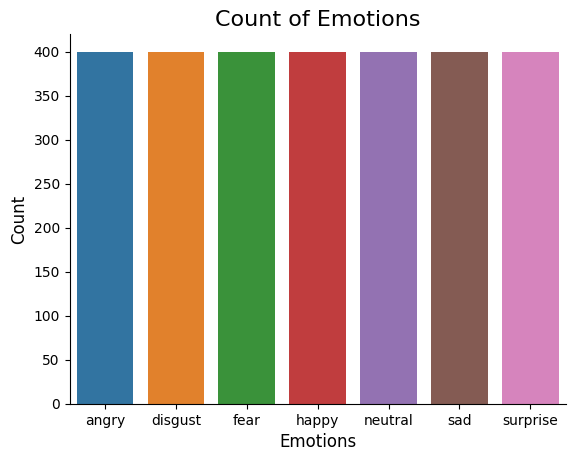

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(x=pd.Categorical(data_path.Emotions))
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [10]:
data,sr = librosa.load(file_path[0])
print(sr)

22050


In [11]:
ipd.Audio(data,rate=sr)

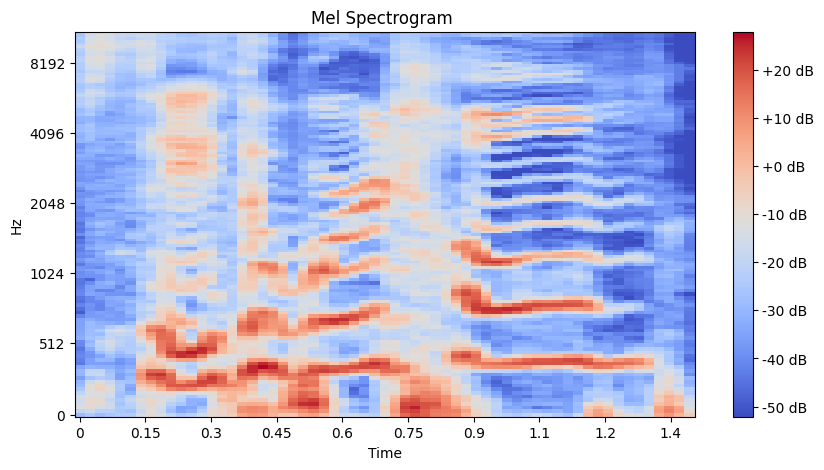

In [12]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

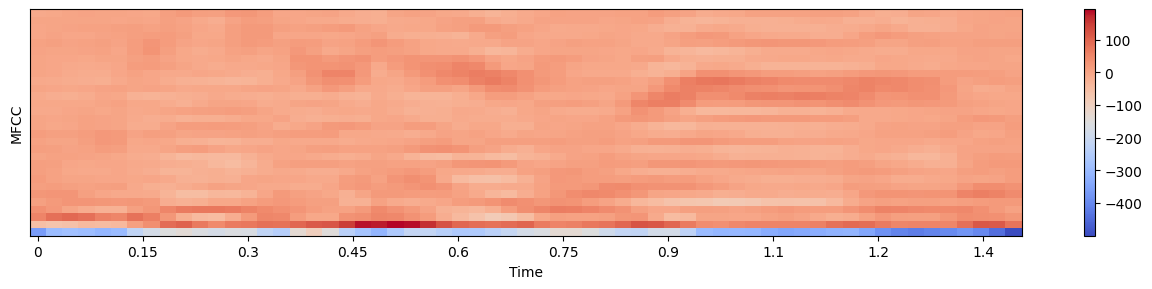

In [13]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)


plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=1.0):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, n_steps=None):
    if n_steps is None:
        n_steps = int(pitch_factor * sampling_rate)
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, pitch_factor=pitch_factor, n_steps=n_steps)

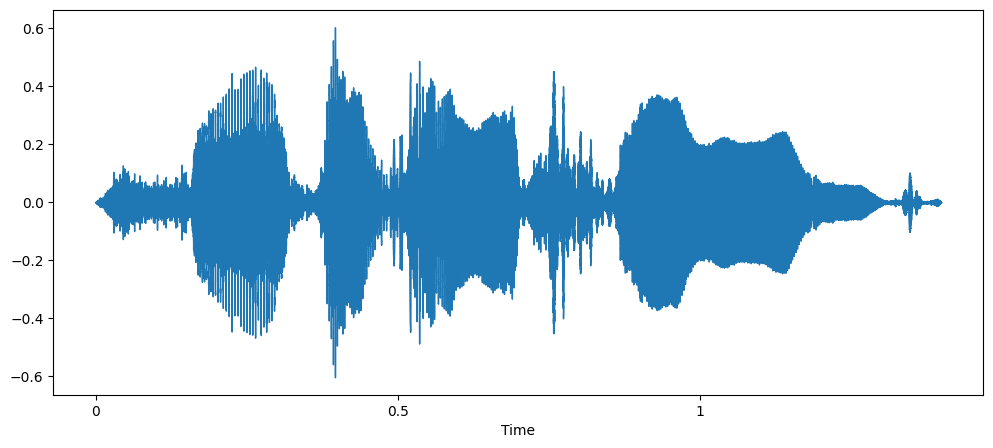

In [15]:
# NORMAL AUDIO

import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

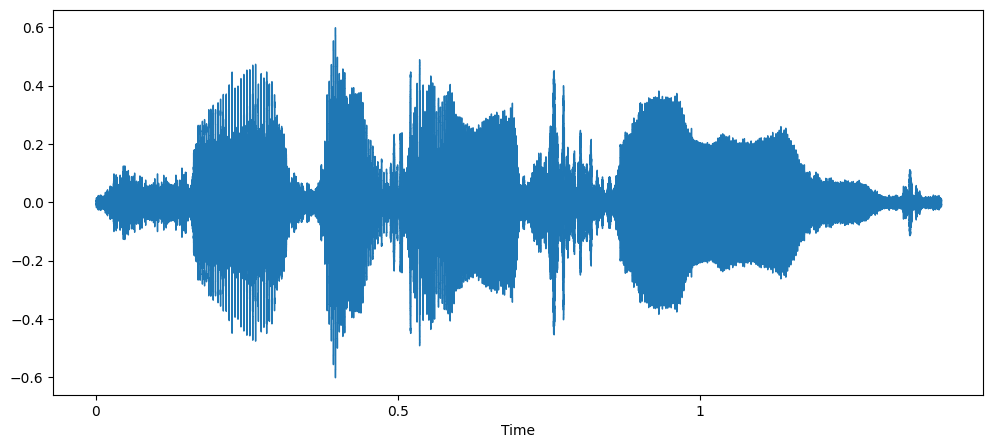

In [16]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

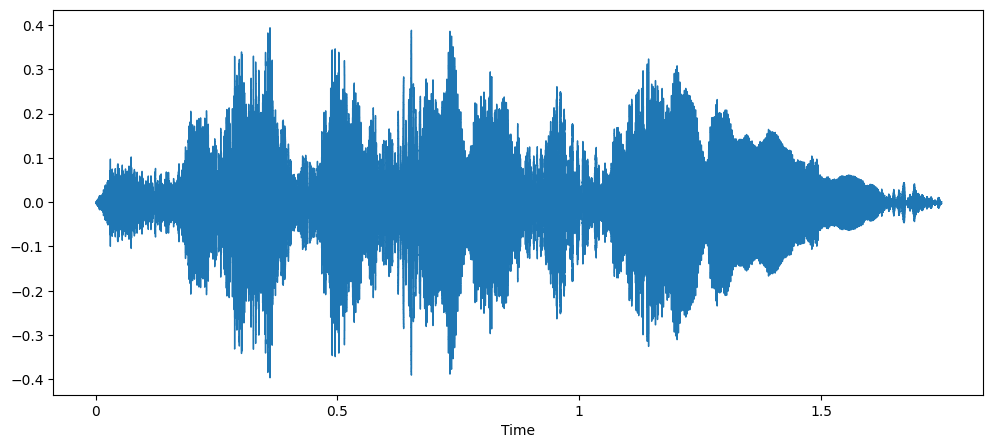

In [17]:
# STRETCHED AUDIO
x = stretch(data,0.8)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

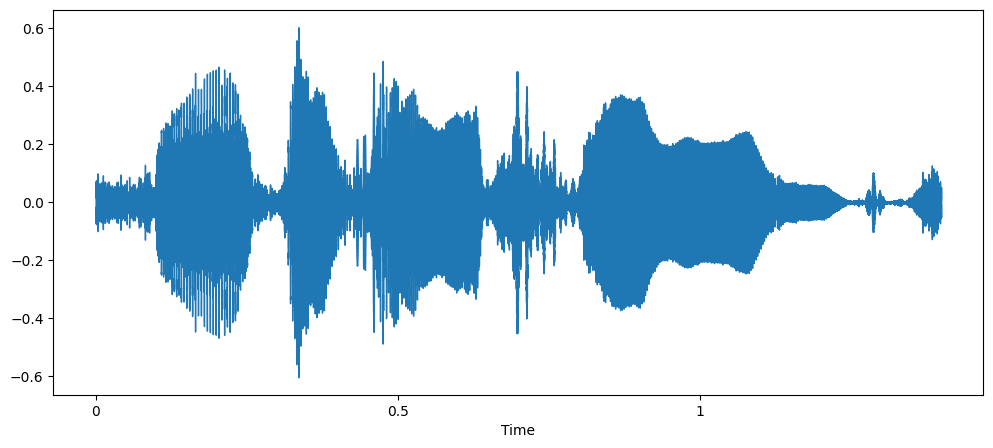

In [18]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

In [19]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)
    
    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))
    
    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))
    
    return audio

In [20]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  4


In [21]:
from joblib import Parallel, delayed
import timeit
import librosa
import timeit
from tqdm import tqdm
start = timeit.default_timer()
def get_features(path, sr=22050, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=13, window='hamming'):
    y, sr = librosa.load(path, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rms = librosa.feature.rms(y=y, frame_length=hop_length, hop_length=hop_length)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    zcr = librosa.feature.zero_crossing_rate(y)
    features = np.vstack((mfccs, chroma, mel, contrast, rms, spec_cent, spec_bw, rolloff, zcr)).T
    return features

def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        Y.append(emotion)
    return X, Y

paths = data_path.Path
emotions = data_path.Emotions
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)

    
stop = timeit.default_timer()
print('Time: ', stop - start)


Time:  81.04960921700001


In [22]:
len(X), len(Y), data_path.Path.shape


(249251, 249251, (2800,))

In [24]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion (4).csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,Emotions
0,-366.890961,-54.348221,53.126919,35.289352,8.715267,23.034008,10.582825,14.715617,10.742308,10.880162,...,12.602273,13.358513,15.516687,33.858658,0.003559,6430.592969,2669.546931,9065.478516,0.291016,fear
1,-297.946747,-64.885811,82.554588,20.729593,17.839394,27.680107,11.907085,4.741816,4.191506,6.889135,...,13.219390,12.549997,17.923939,41.242955,0.024183,7331.592701,2487.168146,9722.241211,0.493164,fear
2,-288.393097,-58.921436,92.885025,-1.321798,27.116732,26.438385,8.609214,-1.025416,-5.646459,-3.444879,...,12.796195,12.781509,19.280776,43.387706,0.043574,7930.624081,2344.447718,10056.005859,0.692871,fear
3,-295.503479,-42.911911,83.868271,-14.457170,26.323860,8.431164,3.947359,-0.743212,-9.141477,-5.892610,...,14.075282,14.969063,20.756977,43.180093,0.031080,8085.586376,2374.228107,10131.372070,0.777344,fear
4,-313.037292,-46.573685,58.738297,-24.508316,23.367191,-4.542042,6.542662,-3.867910,-8.762524,-4.639573,...,18.540572,14.297422,15.621844,44.645061,0.025708,8174.460750,2359.647572,10142.138672,0.803711,fear


In [25]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,Emotions
0,-366.890961,-54.348221,53.126919,35.289352,8.715267,23.034008,10.582825,14.715617,10.742308,10.880162,...,12.602273,13.358513,15.516687,33.858658,0.003559,6430.592969,2669.546931,9065.478516,0.291016,fear
1,-297.946747,-64.885811,82.554588,20.729593,17.839394,27.680107,11.907085,4.741816,4.191506,6.889135,...,13.219390,12.549997,17.923939,41.242955,0.024183,7331.592701,2487.168146,9722.241211,0.493164,fear
2,-288.393097,-58.921436,92.885025,-1.321798,27.116732,26.438385,8.609214,-1.025416,-5.646459,-3.444879,...,12.796195,12.781509,19.280776,43.387706,0.043574,7930.624081,2344.447718,10056.005859,0.692871,fear
3,-295.503479,-42.911911,83.868271,-14.457170,26.323860,8.431164,3.947359,-0.743212,-9.141477,-5.892610,...,14.075282,14.969063,20.756977,43.180093,0.031080,8085.586376,2374.228107,10131.372070,0.777344,fear
4,-313.037292,-46.573685,58.738297,-24.508316,23.367191,-4.542042,6.542662,-3.867910,-8.762524,-4.639573,...,18.540572,14.297422,15.621844,44.645061,0.025708,8174.460750,2359.647572,10142.138672,0.803711,fear


In [26]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
161         False
162         False
163         False
164         False
Emotions    False
Length: 166, dtype: bool


In [27]:
Emotions=Emotions.fillna(0)
print(Emotions.isna().any())
Emotions.shape

0           False
1           False
2           False
3           False
4           False
            ...  
161         False
162         False
163         False
164         False
Emotions    False
Length: 166, dtype: bool


(249251, 166)

In [28]:
np.sum(Emotions.isna())

0           0
1           0
2           0
3           0
4           0
           ..
161         0
162         0
163         0
164         0
Emotions    0
Length: 166, dtype: int64

In [29]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [31]:
print(Y.shape)
X.shape

(249251, 7)


(249251, 165)

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((199400, 165), (199400, 7), (49851, 165), (49851, 7))

In [33]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [34]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((199400, 165), (199400, 7), (49851, 165), (49851, 7))

In [35]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)

In [37]:
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [38]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((199400, 165, 1), (199400, 7), (49851, 165, 1), (49851, 7))

In [39]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2), 
    
    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),
     L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2), 
    
    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(7,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 165, 512)          3072      
                                                                 
 batch_normalization (Batch  (None, 165, 512)          2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 83, 512)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 83, 512)           1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 83, 512)           2048      
 chNormalization)                                                
                                                        

In [40]:
history=model.fit(x_traincnn, y_train, epochs=1, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

3116/3116 [==============================] - 3114s 998ms/step - loss: 1.1601 - accuracy: 0.5604 - val_loss: 1.4714 - val_accuracy: 0.4712 - lr: 0.0010


In [95]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

1558/1558 [==============================] - 140s 90ms/step - loss: 1.4714 - accuracy: 0.4712
Accuracy of our model on test data :  47.11640775203705 %


In [90]:
# predicting
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(100)

1558/1558 [==============================] - 137s 88ms/step


,Predicted Labels,Actual Labels
0,surprise,surprise
1,happy,fear
2,angry,happy
3,angry,neutral
4,happy,sad
...,...,...
95,sad,sad
96,neutral,neutral
97,surprise,surprise
98,neutral,disgust


In [94]:
print(df0[:60])

   Predicted Labels Actual Labels
0          surprise      surprise
1             happy          fear
2             angry         happy
3             angry       neutral
4             happy           sad
5             angry         happy
6              fear          fear
7           disgust           sad
8           disgust      surprise
9             happy           sad
10            angry         happy
11          neutral           sad
12              sad           sad
13            angry          fear
14              sad           sad
15            happy         happy
16          disgust       disgust
17            angry         angry
18            happy         happy
19             fear          fear
20            happy         happy
21            angry      surprise
22          disgust         angry
23            angry         angry
24            angry       disgust
25            angry         angry
26            angry      surprise
27            happy          fear
28          ne

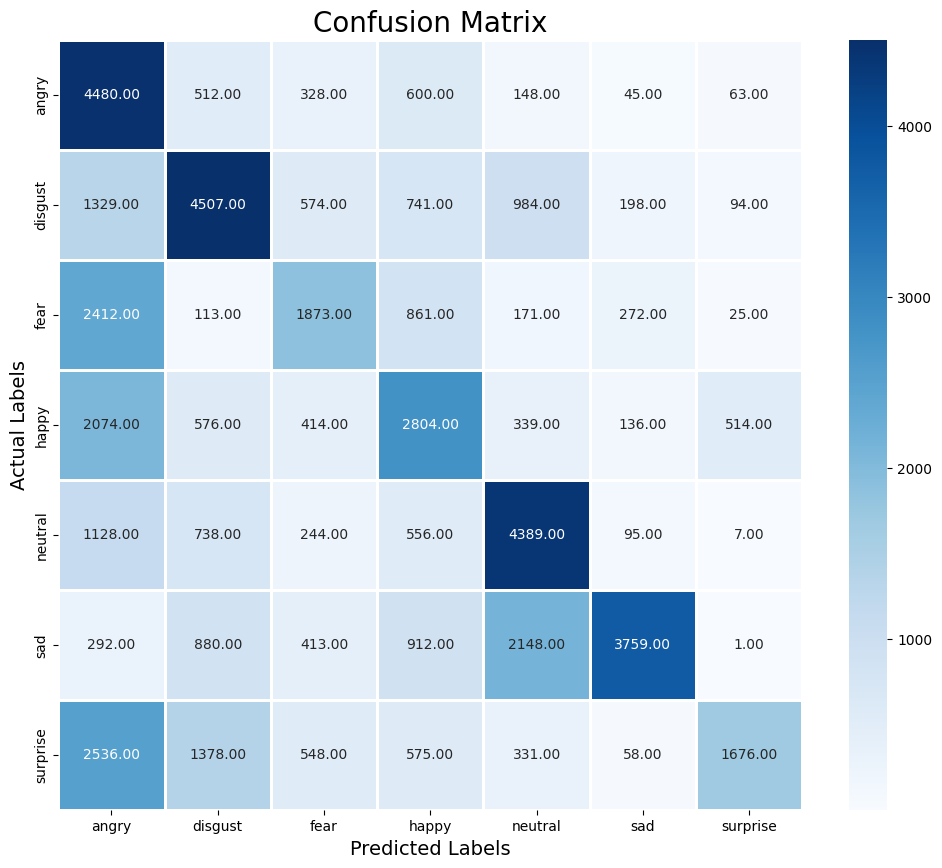

              precision    recall  f1-score   support

       angry       0.31      0.73      0.44      6176
     disgust       0.52      0.53      0.53      8427
        fear       0.43      0.33      0.37      5727
       happy       0.40      0.41      0.40      6857
     neutral       0.52      0.61      0.56      7157
         sad       0.82      0.45      0.58      8405
    surprise       0.70      0.24      0.35      7102

    accuracy                           0.47     49851
   macro avg       0.53      0.47      0.46     49851
weighted avg       0.54      0.47      0.47     49851



In [43]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

In [44]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
with open("CNN_model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("CNN_model_weights.h5")
print("Saved model to disk") 

Saved model to disk


In [45]:
from tensorflow.keras.models import Sequential, model_from_json
json_file = open('/kaggle/working/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [46]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

1558/1558 [==============================] - 136s 87ms/step - loss: 1.4714 - accuracy: 0.4712
accuracy: 47.12%
